In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import itertools

import numpy as np
import bottleneck as bn
import pandas as pd
from sklearn import decomposition
import networkx as nx
# import networkx.algorithms.approximation as nxa
import igraph as ig
# # http://stackoverflow.com/questions/35279733/what-could-cause-networkx-pygraphviz-to-work-fine-alone-but-not-together
# from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import palettable
import pickle
import lmfit
%matplotlib inline

np.set_printoptions(linewidth=145)
np.set_printoptions(precision=5)

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
warnings.simplefilter("ignore", category=UserWarning)


from collections import defaultdict, Counter
from IPython.display import display as disp
from IPython.display import display_markdown
mdisp = lambda s: display_markdown(s, raw=True)

from speclib import loaders
from speclib import plotting
from speclib import graph
from speclib import misc
from speclib import userActivityFunctions

for k, v in {'font.size': 13.0,
             'legend.fontsize': 13.0,
             'axes.labelsize': 12.0,
             'axes.titlesize': 15.0,
             'figure.figsize': [10.0, 6.0],
             'figure.dpi': 200,
             'figure.titlesize': 'large',
             'xtick.labelsize': 13.0,
             'ytick.labelsize': 13.0,
             'text.usetex': True}.items():
    mpl.rcParams[k] = v

import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle) 

%load_ext watermark
%watermark -a "Allan Leander Rostock Hansen" -u -d -v -p numpy,bottleneck,pandas,matplotlib,sklearn,missingno
%watermark  -p networkx,igraph,seaborn,palettable,lmfit

Allan Leander Rostock Hansen 
last updated: 2018-10-14 

CPython 3.6.4
IPython 6.2.1

numpy 1.14.5
bottleneck 1.2.1
pandas 0.22.0
matplotlib 2.1.2
sklearn 0.19.1
missingno 0.4.0
networkx 2.2
igraph 0.7.1
seaborn 0.9.0
palettable 3.1.0
lmfit 0.9.7


In [27]:
mpl.rcParams['figure.figsize'] = [10.0, 6.0]

## Load the data

In [21]:
with open('pca_result_clique.pickle', 'rb') as fid:
    res = pickle.load(fid) 
    df = pd.DataFrame(res, columns=['clique', 'pca']) 
    df['cliquesize'] = df['clique'].apply(lambda lst: len(lst))
    print(f"{df.pca.isnull().sum()} null-rows in the dataframe were removed, out of {df.shape[0]} rows in total.") 
    df = df.dropna() 
    del res

3 null-rows in the dataframe were removed, out of 411 rows in total.


In [12]:
df.isna()

clique        0
pca           0
cliquesize    0
dtype: int64

In [14]:
df.loc[df.isna().any(axis=1)]

,clique,pca,cliquesize
166,"[u0451, u0216, u0567]",None,3
291,"[u0673, u0492, u0838]",None,3
406,"[u0859, u0819, u0893]",None,3


In [22]:
df.columns

Index(['clique', 'pca', 'cliquesize'], dtype='object')

In [23]:
df.head() 

,clique,pca,cliquesize
0,"[u0489, u0491, u0758, u0287, u0128, u0813]","PCA(copy=True, iterated_power='auto', n_compon...",6
1,"[u0683, u0388, u0446, u0618, u0645, u0993]","PCA(copy=True, iterated_power='auto', n_compon...",6
2,"[u0324, u0287, u0758, u0128, u0813, u0444]","PCA(copy=True, iterated_power='auto', n_compon...",6
3,"[u0154, u0758, u0491, u0128, u0489, u0813]","PCA(copy=True, iterated_power='auto', n_compon...",6
4,"[u0324, u0287, u0758, u0128, u0813, u0491]","PCA(copy=True, iterated_power='auto', n_compon...",6


## Explanation power 

Compute number of components for 95 % explanation power, and make a histogram of it

In [24]:
thresh = 0.95
df['ep'] = df.pca.apply(lambda pca: (np.cumsum(pca.explained_variance_ratio_) < thresh).sum())
df['epcom'] = df.ep / df.cliquesize
df.head() 

,clique,pca,cliquesize,ep,epcom
0,"[u0489, u0491, u0758, u0287, u0128, u0813]","PCA(copy=True, iterated_power='auto', n_compon...",6,16,2.666667
1,"[u0683, u0388, u0446, u0618, u0645, u0993]","PCA(copy=True, iterated_power='auto', n_compon...",6,15,2.500000
2,"[u0324, u0287, u0758, u0128, u0813, u0444]","PCA(copy=True, iterated_power='auto', n_compon...",6,12,2.000000
3,"[u0154, u0758, u0491, u0128, u0489, u0813]","PCA(copy=True, iterated_power='auto', n_compon...",6,13,2.166667
4,"[u0324, u0287, u0758, u0128, u0813, u0491]","PCA(copy=True, iterated_power='auto', n_compon...",6,15,2.500000


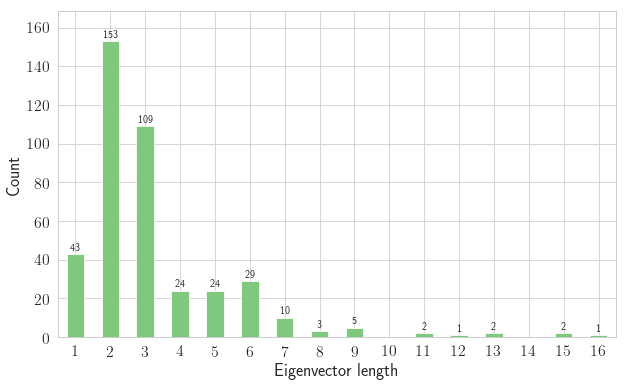

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
cnt = df.ep.value_counts().sort_index() 
cnt.reindex(np.arange(cnt.index.min(), cnt.index.max()+1)).plot.bar(rot=0, color=colorcycle[0], ax=ax) 
plotting.countsOnBarPlot(ax)
ax.set_xlabel('Eigenvector length')
ax.set_ylabel('Count');
ax.set_xticklabels([f"${lbl.get_text()}$" for lbl in ax.get_xticklabels()])
plotting.looseAxesLimits(ax, loosen=(0, 0, 0, 0.05))
fig.savefig("figs/pca_cliques_eigenvector_lengths_histogram.pdf")

Plotting histograms and KDE's for each clique size

Text(0.5,0,'Explanation Power / community size')

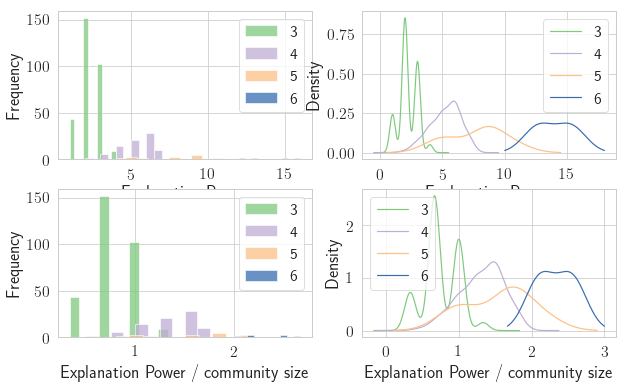

In [29]:
fig, axi = plt.subplots(2, 2)
ax0, ax1, ax2 ,ax3 = axi.flat

df.groupby('cliquesize').ep.plot.hist(legend=True, alpha=0.75, ax=ax0)
ax0.set_xlabel('Explanation Power')

df.groupby('cliquesize').ep.plot.kde(legend=True, ax=ax1); 
ax1.set_xlabel('Explanation Power')

df.groupby('cliquesize').epcom.plot.hist(legend=True, alpha=0.75, ax=ax2) 
ax2.set_xlabel('Explanation Power / community size')

df.groupby('cliquesize').epcom.plot.kde(legend=True, ax=ax3); 
ax3.set_xlabel('Explanation Power / community size')

Same plot as above, but each in it's ovn figure.

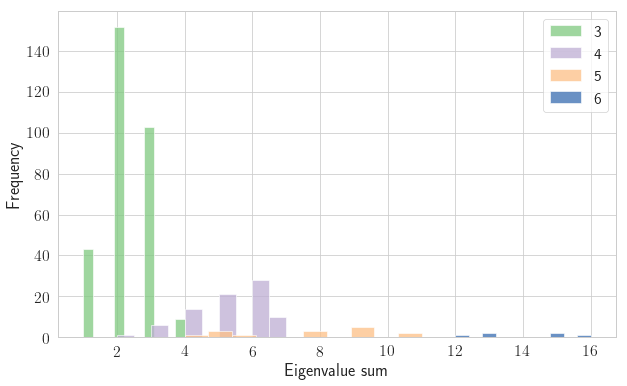

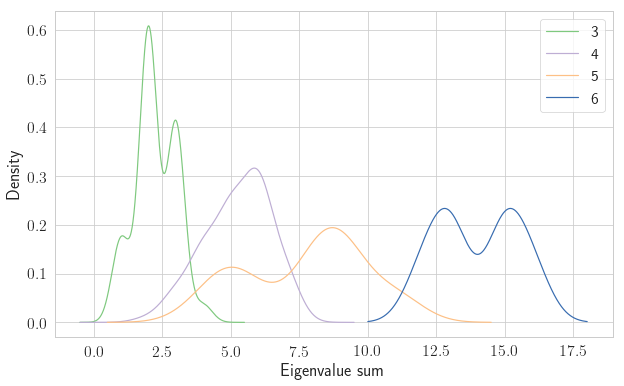

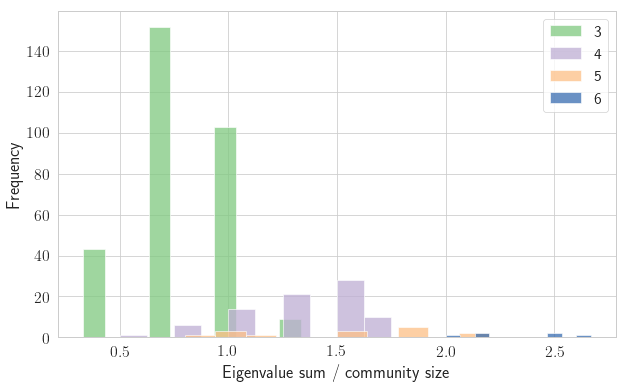

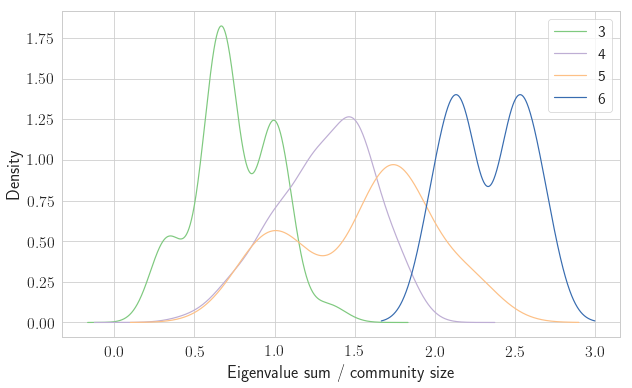

In [64]:
fig, ax = plt.subplots()
df.groupby('cliquesize').ep.plot.hist(legend=True, alpha=0.75, ax=ax)
ax.set_xlabel('Eigenvalue sum')
fig.savefig("figs/eigenvalue_sum_hist.pdf")

fig, ax = plt.subplots()
df.groupby('cliquesize').ep.plot.kde(legend=True, bw_method=0.45, ax=ax); 
ax.set_xlabel('Eigenvalue sum')
fig.savefig("figs/eigenvalue_sum_kde.pdf")

fig, ax = plt.subplots()
df.groupby('cliquesize').epcom.plot.hist(legend=True, alpha=0.75, ax=ax) 
ax.set_xlabel('Eigenvalue sum / community size')
fig.savefig("figs/eigenvalue_sum_over_community_size_hist.pdf")

fig, ax = plt.subplots()
df.groupby('cliquesize').epcom.plot.kde(legend=True, bw_method=0.45, ax=ax); 
ax.set_xlabel('Eigenvalue sum / community size')
fig.savefig("figs/eigenvalue_sum_over_community_size_kde.pdf")


Also plot the explanation power divided with the number of people in the clique

Histogram as a pcolor-map 

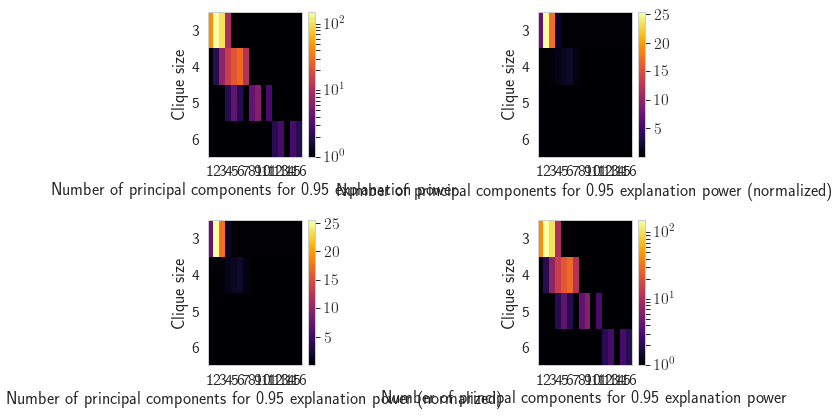

In [34]:
csu = df.cliquesize.unique() 
pcm = np.zeros((len(csu), df.ep.max()))
for csi in range(len(csu)):
    cs = csu[csi]
    wc = df[df.cliquesize == cs].ep.value_counts()
    for i, v in wc.to_dict().items():
        pcm[csi, i-1] = v  # -1 because of 0-indexing

# pcm += np.finfo(float).eps  # make sure that all elements are > 0 because of log-scaling
pcm += 1
fig, axi = plt.subplots(2, 2)
for i in range(4):
    if i == 1 or i == 2:  # Normalized with clique size 
        pcmp = pcm / df.cliquesize.value_counts().values[:, np.newaxis]
        axi.flat[i].set_xlabel('Number of principal components for %.2f explanation power (normalized)' % thresh)
    else:  # Don't normalize
        pcmp = pcm
        axi.flat[i].set_xlabel('Number of principal components for %.2f explanation power' % thresh)
    if i == 0 or i == 3:  # Log scaling
        pc = axi.flat[i].pcolor(pcmp, cmap='inferno',
                       norm=mpl.colors.LogNorm(vmin=pcmp.min(), vmax=pcmp.max()))
    else:  # Normal scaling
        pc = axi.flat[i].pcolor(pcmp, cmap='inferno', vmin=pcmp.min(), vmax=pcmp.max())

    fig.colorbar(pc, ax=axi.flat[i]) 
    axi.flat[i].yaxis.set(ticks=np.arange(0.5, len(csu)), ticklabels=csu)
    axi.flat[i].xaxis.set(ticks=np.arange(0.5, df.ep.max()), ticklabels=np.arange(1, df.ep.max()+1))
    axi.flat[i].set_ylabel('Clique size')  
fig.tight_layout(pad=1.5)

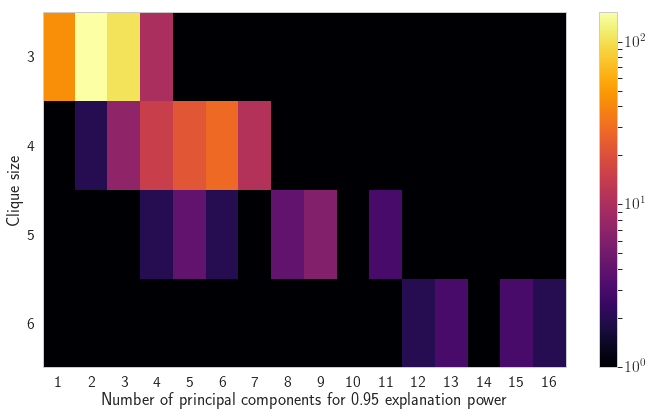

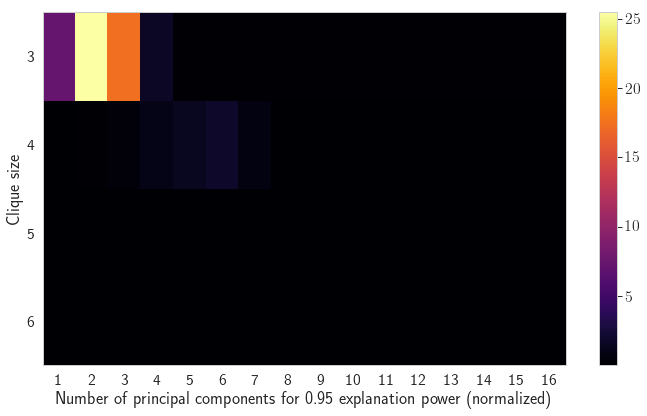

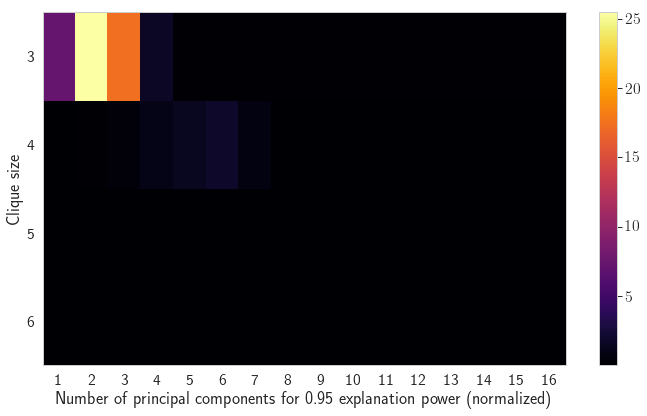

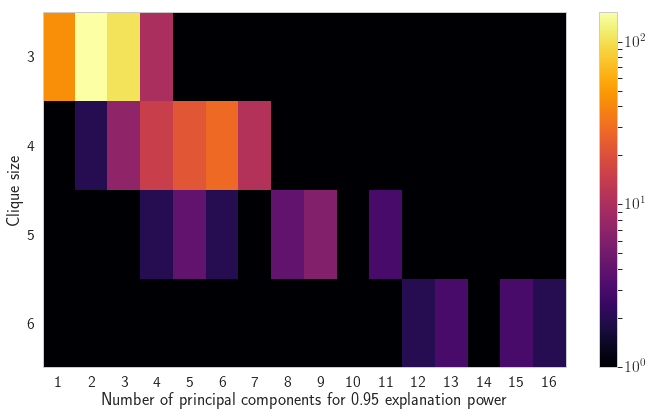

In [35]:
for i in range(4):
    fig, ax = plt.subplots()
    if i in {1, 2}:  # Normalized with clique size 
        pcmp = pcm / df.cliquesize.value_counts().values[:, np.newaxis]
        name = "Number of principal components for %.2f explanation power (normalized)" % thresh
        ax.set_xlabel(name)
        name = '_'.join(name.split(' ')[:-1]) + " normalized wrt clique size"
    else:  # Don't normalize
        pcmp = pcm
        name = "Number of principal components for %.2f explanation power" % thresh
        ax.set_xlabel(name)
        name = '_'.join(name.split(' '))
    if i in {0, 3}:  # Log scaling
        pc = ax.pcolor(pcmp, cmap='inferno', norm=mpl.colors.LogNorm(vmin=pcmp.min(), vmax=pcmp.max()))
        name = name + '_log'
    else:  # Normal scaling
        pc = ax.pcolor(pcmp, cmap='inferno', vmin=pcmp.min(), vmax=pcmp.max())

    fig.colorbar(pc)#, ax=ax.flat[i]) 
    ax.yaxis.set(ticks=np.arange(0.5, len(csu)), ticklabels=csu)
    ax.xaxis.set(ticks=np.arange(0.5, df.ep.max()), ticklabels=np.arange(1, df.ep.max()+1))
    ax.set_ylabel('Clique size')  
    fig.tight_layout(pad=1.5)
    fig.savefig(f"figs/{name}.pdf")


## Graph similarity

In [36]:
df.head()

,clique,pca,cliquesize,ep,epcom
0,"[u0489, u0491, u0758, u0287, u0128, u0813]","PCA(copy=True, iterated_power='auto', n_compon...",6,16,2.666667
1,"[u0683, u0388, u0446, u0618, u0645, u0993]","PCA(copy=True, iterated_power='auto', n_compon...",6,15,2.500000
2,"[u0324, u0287, u0758, u0128, u0813, u0444]","PCA(copy=True, iterated_power='auto', n_compon...",6,12,2.000000
3,"[u0154, u0758, u0491, u0128, u0489, u0813]","PCA(copy=True, iterated_power='auto', n_compon...",6,13,2.166667
4,"[u0324, u0287, u0758, u0128, u0813, u0491]","PCA(copy=True, iterated_power='auto', n_compon...",6,15,2.500000


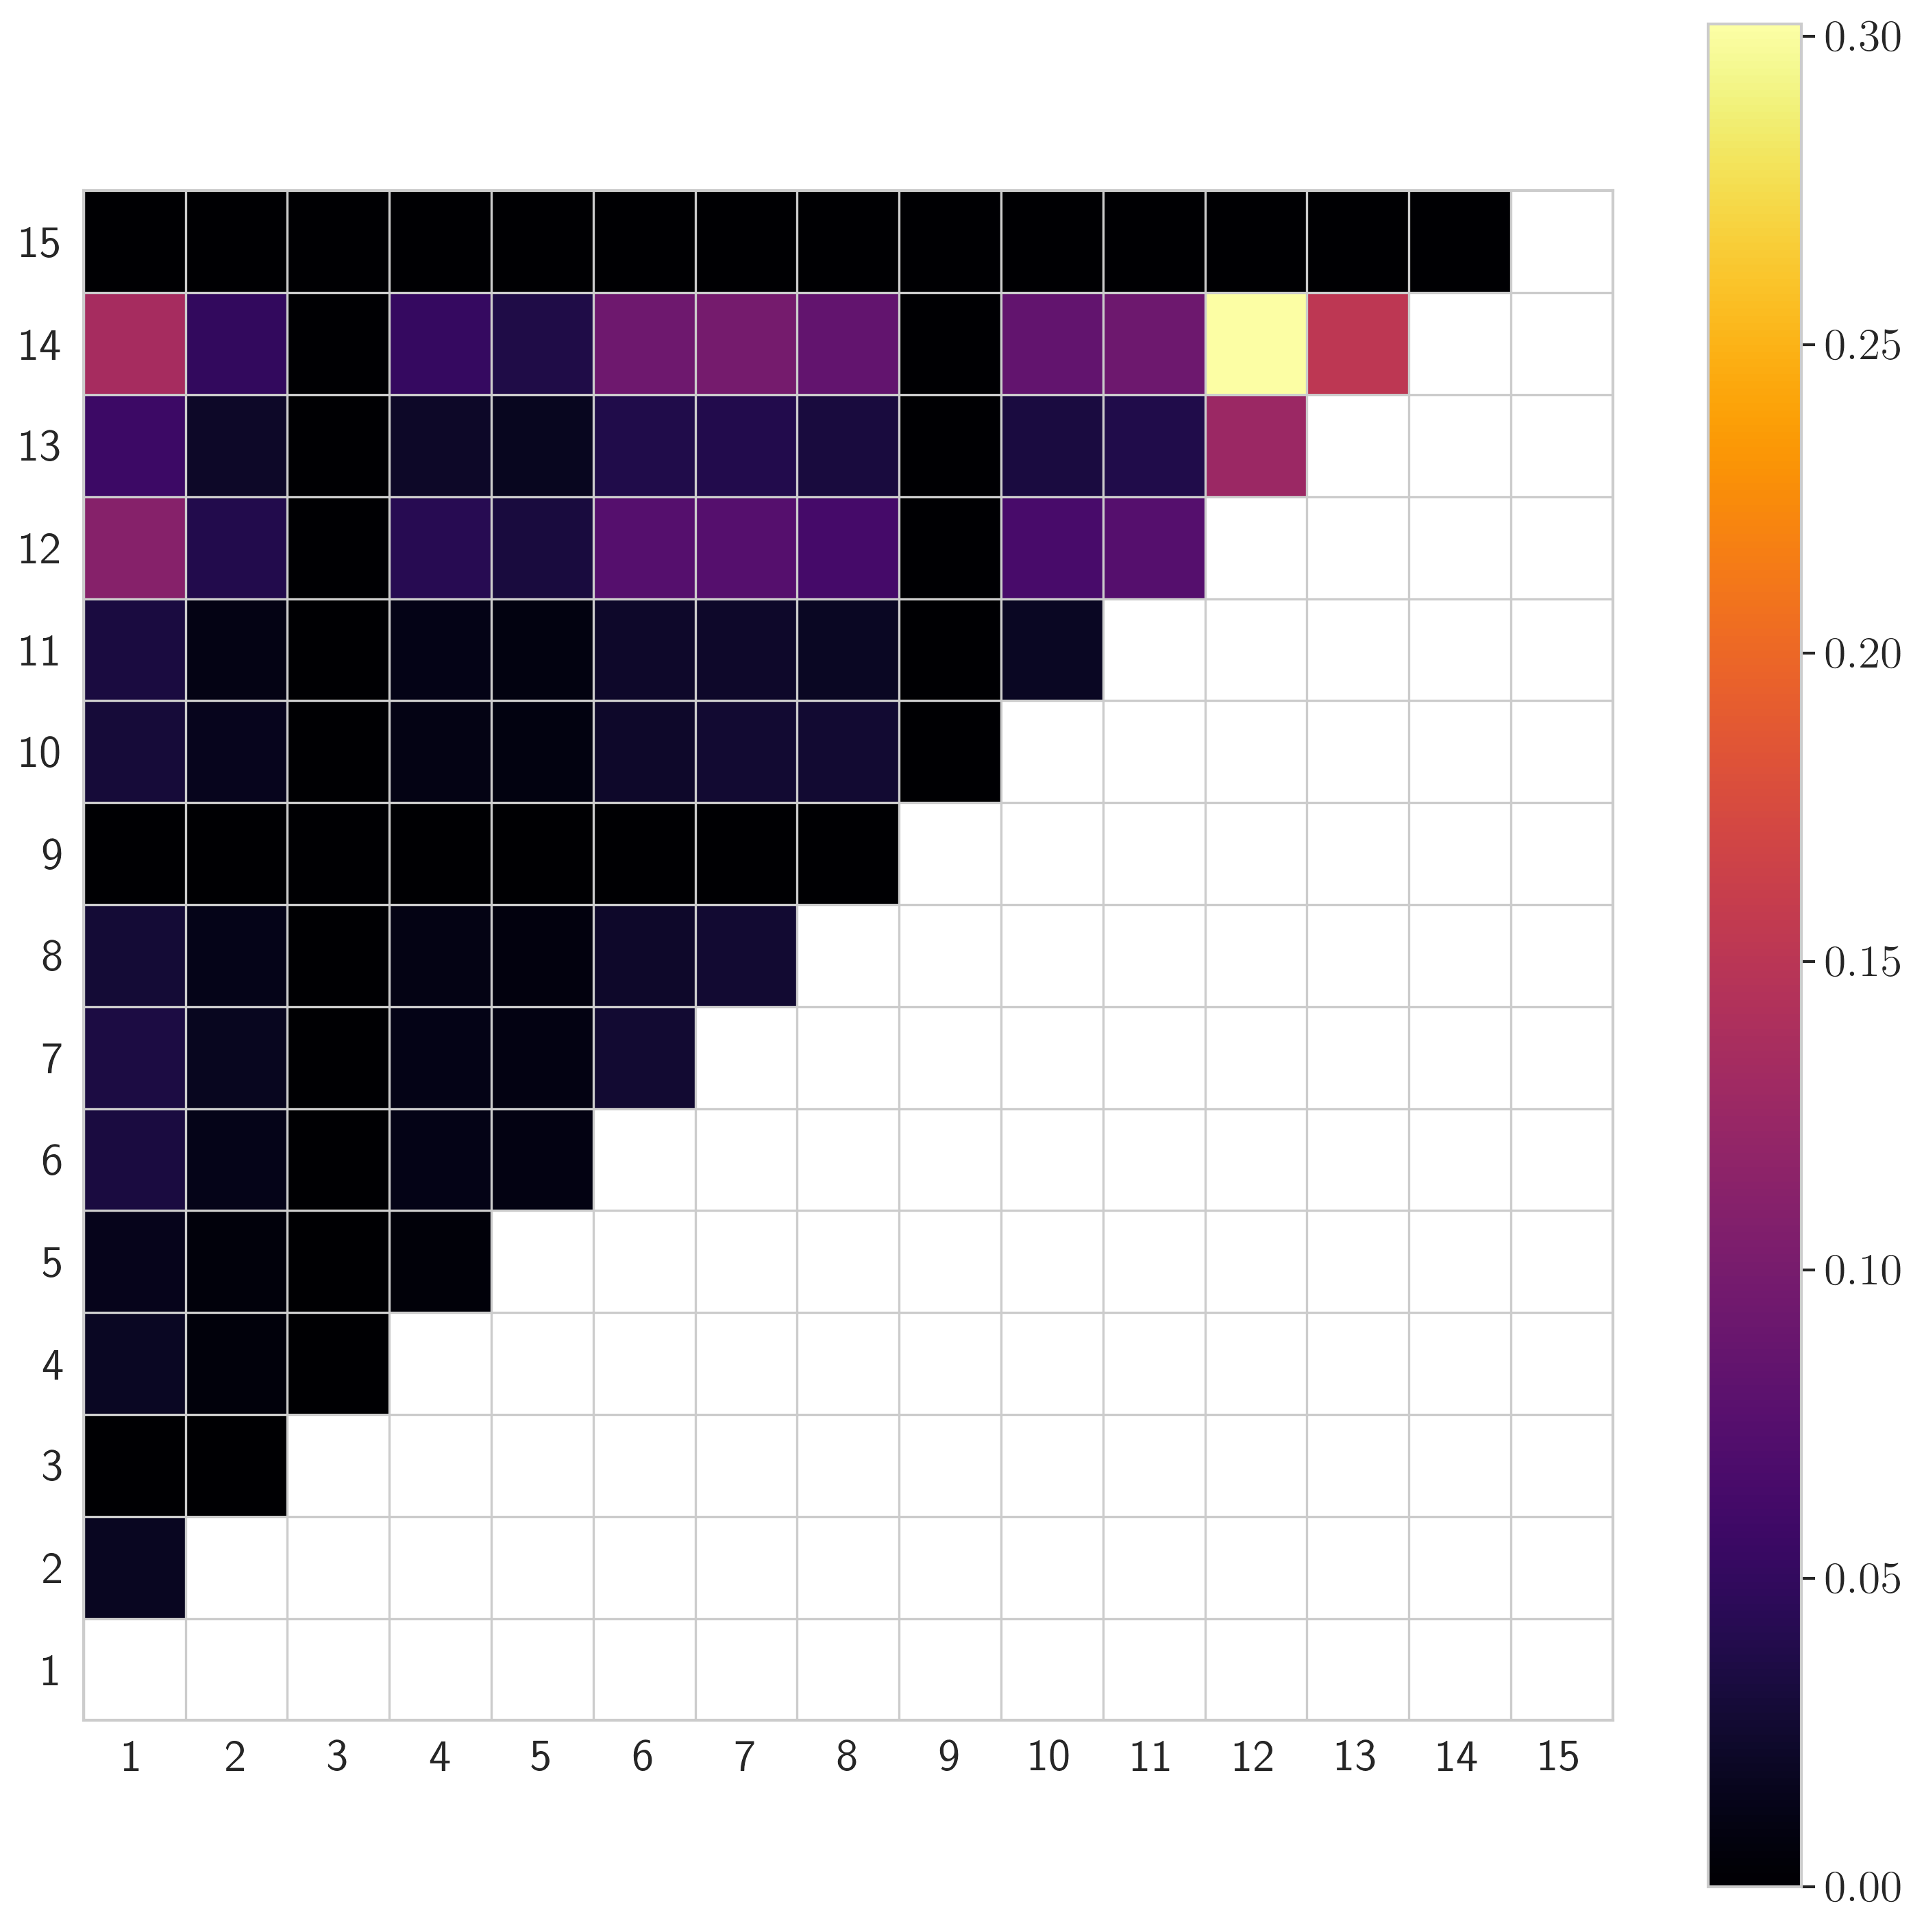

In [37]:
k = 1
eps = 1e-8
ep = df.iloc[k].ep
comp = df.iloc[k].pca.components_[:, :ep]
comp[comp < eps] = 0

arr = np.NaN*np.ones((ep, ep))
for i, j in ((i, j) for i in range(ep) for j in range(i)):
    mi = graph.vec2squareMat(comp[:, i], addDiagonal=True)
    mj = graph.vec2squareMat(comp[:, j], addDiagonal=True)
    dp = graph.dotproductGraphCompare(mi, mj)
    arr[i, j] = dp
    # arr[j, i] = dp

fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
pc = ax.pcolorfast(arr, cmap='inferno')
fig.colorbar(pc)
ax.set_aspect('equal') 

# get nice ticks and labels
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_xticks(np.arange(arr.shape[0]))
ax.set_yticks(np.arange(arr.shape[0]))
ax.set_xticks(np.arange(arr.shape[0]) + 0.5, minor=True)
ax.set_xticklabels(np.arange(arr.shape[0]) + 1, minor=True)
ax.set_yticks(np.arange(arr.shape[0]) + 0.5, minor=True)
ax.set_yticklabels(np.arange(arr.shape[0]) + 1, minor=True)

ax.grid(True);

fig.savefig("figs/graph_similarity_heatmap_dotproduct_graph_compare.pdf")

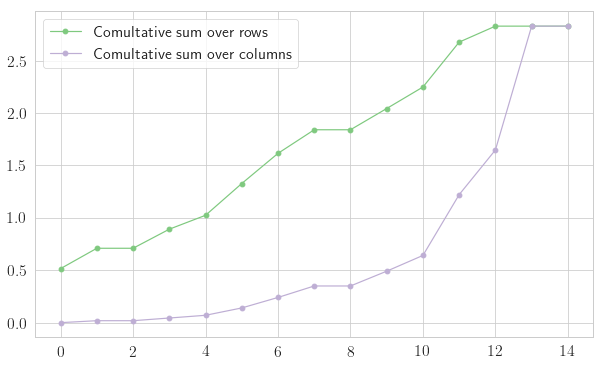

In [38]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(np.nansum(arr, axis=0)), '-o', label="Comultative sum over rows")
ax.plot(np.cumsum(np.nansum(arr, axis=1)), '-o', label="Comultative sum over columns")
ax.legend(loc='best') 
fig.savefig("figs/graph_similarity_row_column_sum_comultative_dotproduct_graph_compare.pdf")

Get the indices corresponding to the largest value

In [39]:
np.unravel_index(np.nanargmax(arr), arr.shape)

(13, 11)

Plot the graphs associated with that value

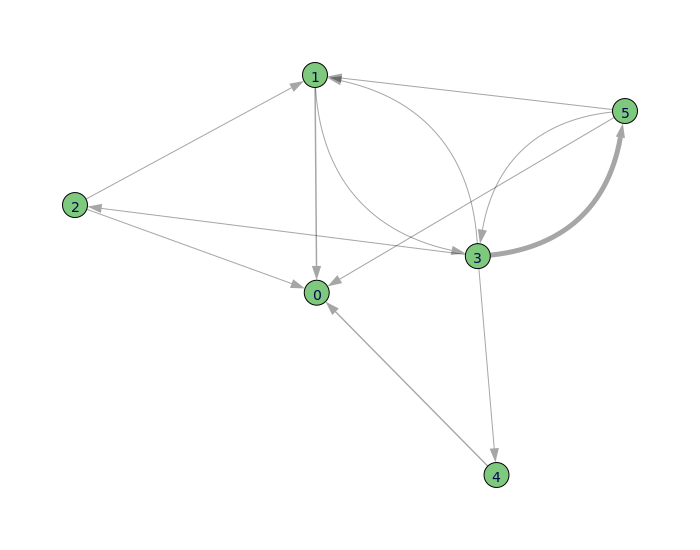

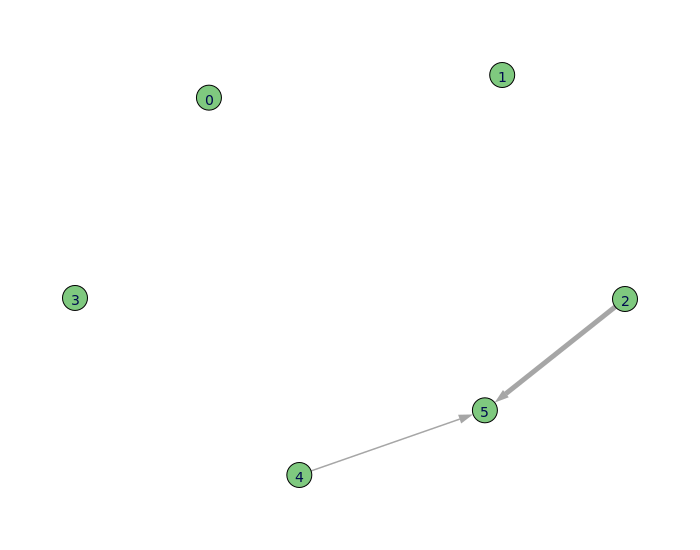

In [40]:
g11, g13 = comp[:, np.unravel_index(np.nanargmax(arr), arr.shape)].T
g11a, g13a = graph.vec2squareMat(g11, addDiagonal=True), graph.vec2squareMat(g13, addDiagonal=True)
g11i, g13i = graph.adjmat2igraph(g11a), graph.adjmat2igraph(g13a)
disp(plotting.igdraw(g11i, vertex_color='rgb(127, 201, 127)'),
     plotting.igdraw(g13i, vertex_color='rgb(127, 201, 127)') ) 

## Fitting the histogram

Try fitting the histogram to a powerlaw and an exponential decay.
The first bin is excluded… so not really that meaningful.

## Community data

In [51]:
with open('pca_result_community.pickle', 'br') as fid:
    res = pickle.load(fid)

[len(res[i][0]) for i in range(len(res))] 

[14, 6, 5, 5, 5, 5, 5, 5]

In [52]:
thresh = 0.95
df = pd.DataFrame(res)
df[0] = df[0].apply(lambda lst: len(lst))
df.columns = ['comsize', 'pca']
print(f"There's {df.pca.isnull().sum()} null-rows in the dataframe, out of {df.shape[0]} rows.") 
df = df.dropna() 
df['ep'] = df.pca.apply(lambda pca: (np.cumsum(pca.explained_variance_ratio_) < thresh).sum())
df['epcom'] = df.ep / df.comsize
df

There's 0 null-rows in the dataframe, out of 8 rows.


,comsize,pca,ep,epcom
0,14,"PCA(copy=True, iterated_power='auto', n_compon...",43,3.071429
1,6,"PCA(copy=True, iterated_power='auto', n_compon...",15,2.500000
2,5,"PCA(copy=True, iterated_power='auto', n_compon...",9,1.800000
3,5,"PCA(copy=True, iterated_power='auto', n_compon...",5,1.000000
4,5,"PCA(copy=True, iterated_power='auto', n_compon...",5,1.000000
5,5,"PCA(copy=True, iterated_power='auto', n_compon...",5,1.000000
6,5,"PCA(copy=True, iterated_power='auto', n_compon...",9,1.800000
7,5,"PCA(copy=True, iterated_power='auto', n_compon...",4,0.800000


# Analyzing the ICA results

In [53]:
with open('ica_result_clique.pickle', 'br') as fid:
    res = pickle.load(fid)

thresh = 0.95
df = pd.DataFrame(res)
df[0] = df[0].apply(lambda lst: len(lst))
df.columns = ['cliquesize', 'pca']
print(f"There's {df.pca.isnull().sum()} null-rows in the dataframe, out of {df.shape[0]} rows.") 
df = df.dropna() 
#df['ep'] = df.pca.apply(lambda pca: (np.cumsum(pca.explained_variance_ratio_) < thresh).sum())
#df['epcom'] = df.ep / df.cliquesize
df.head() 

There's 45 null-rows in the dataframe, out of 411 rows.


,cliquesize,pca
0,6,"FastICA(algorithm='parallel', fun='logcosh', f..."
1,6,"FastICA(algorithm='parallel', fun='logcosh', f..."
2,6,"FastICA(algorithm='parallel', fun='logcosh', f..."
3,6,"FastICA(algorithm='parallel', fun='logcosh', f..."
4,6,"FastICA(algorithm='parallel', fun='logcosh', f..."


### i = 0

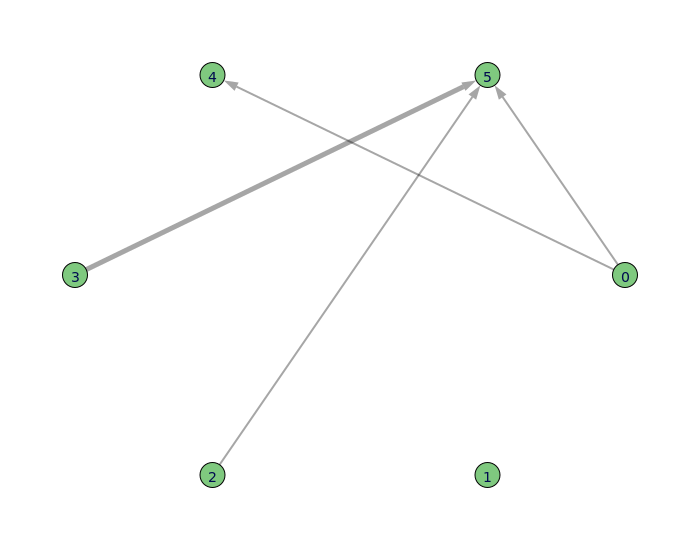

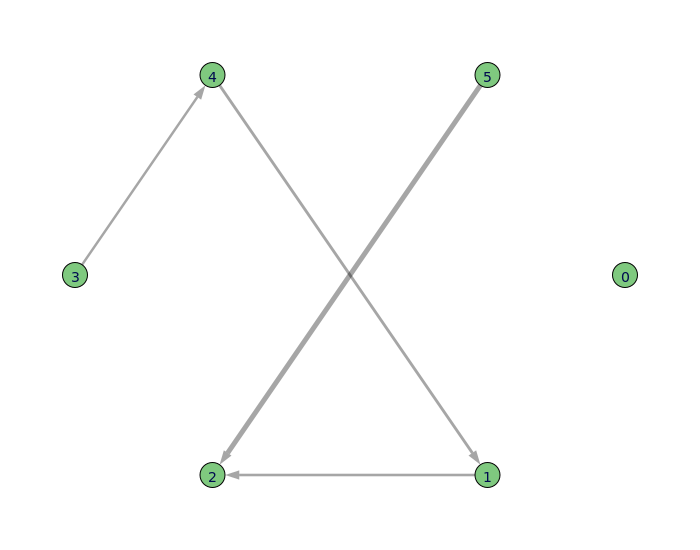

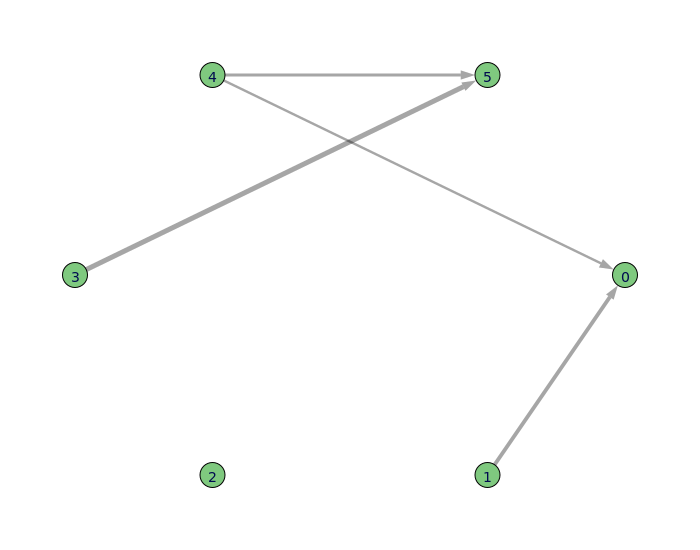

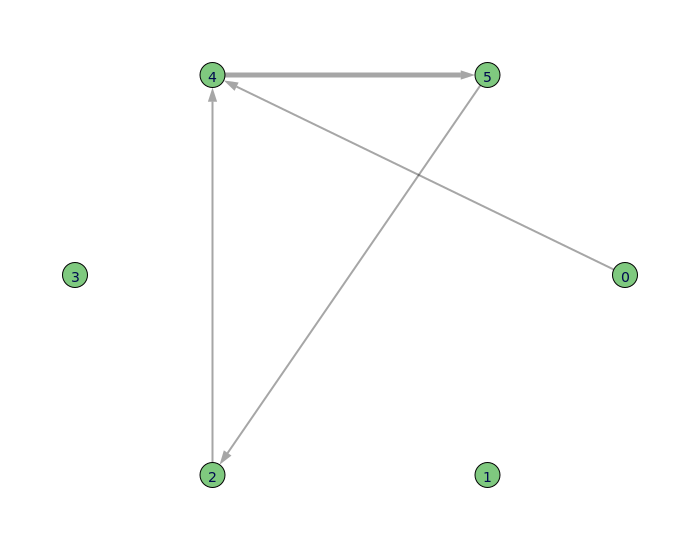

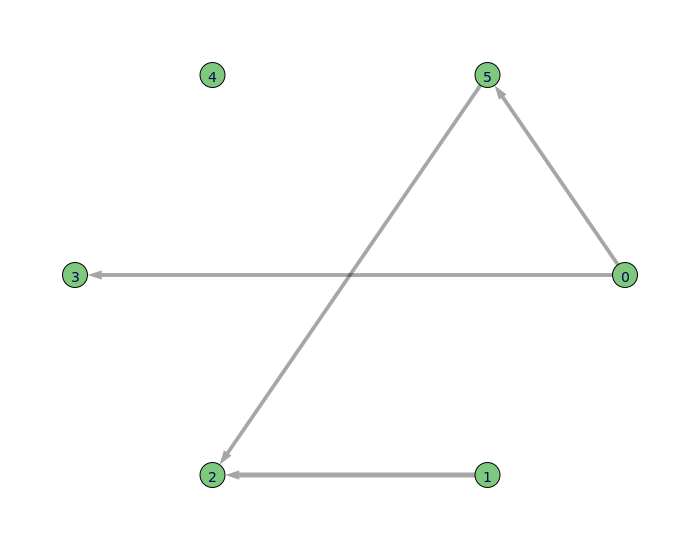

### i = 1

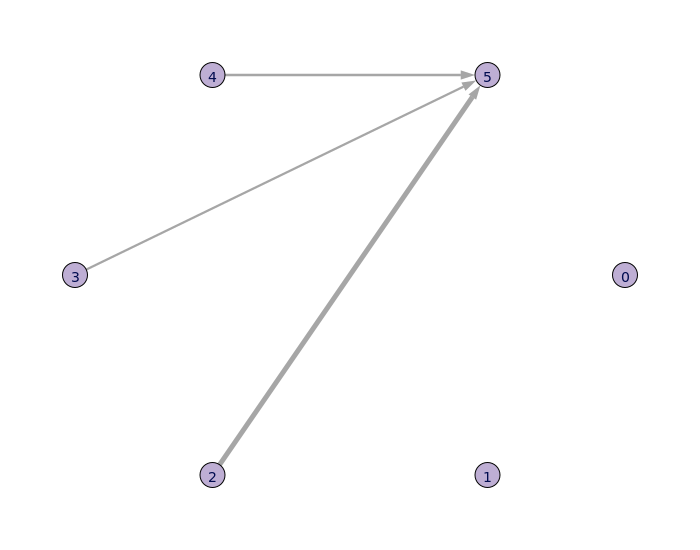

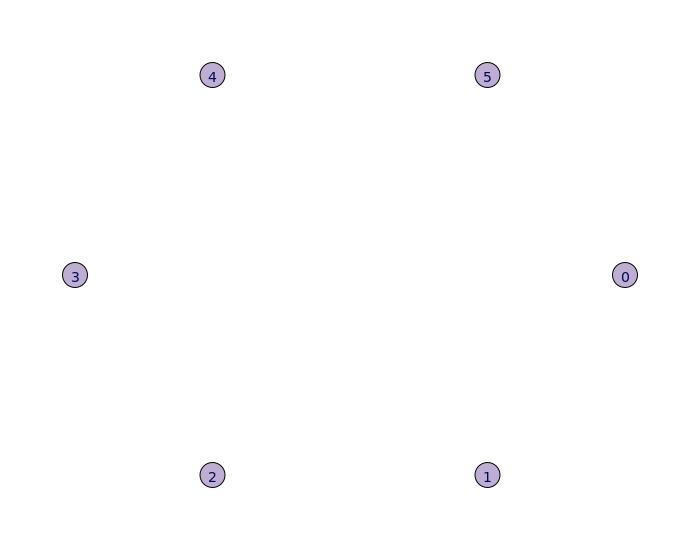

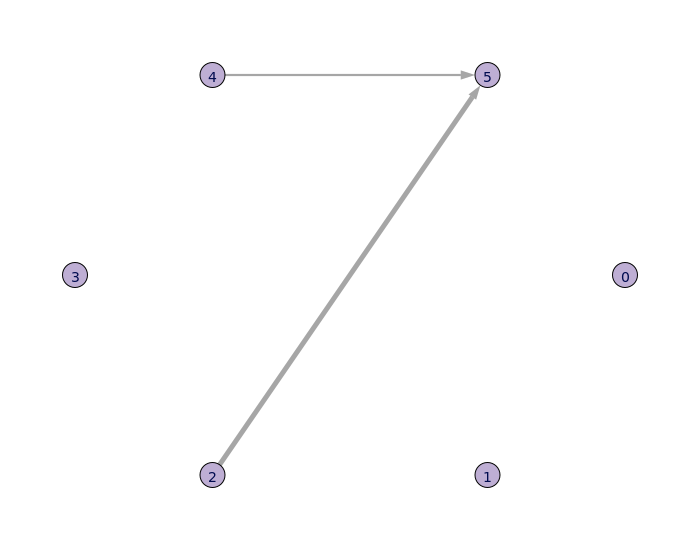

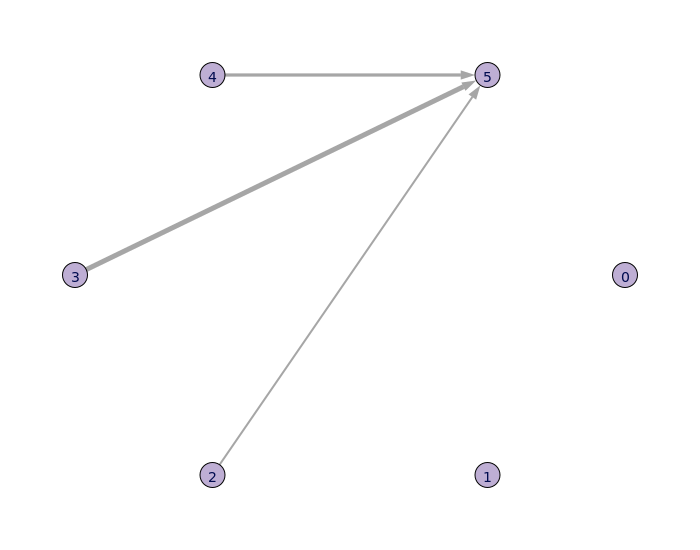

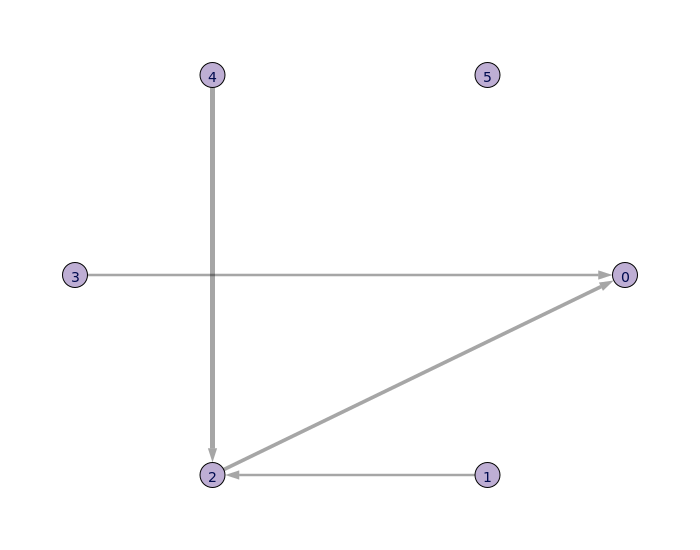

### i = 2

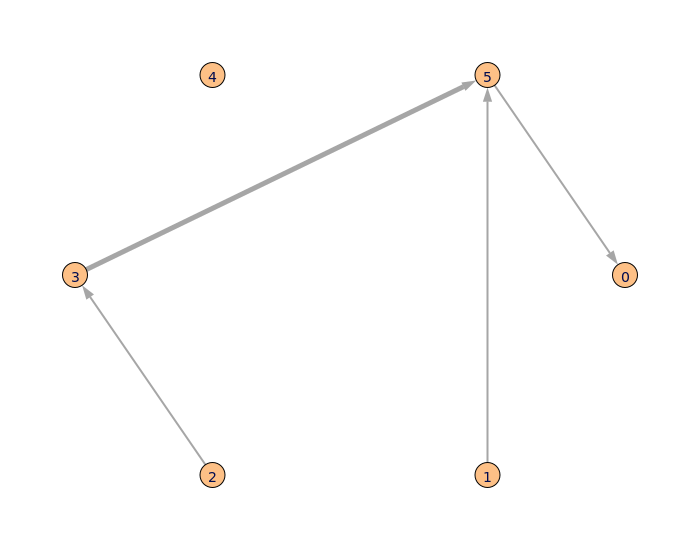

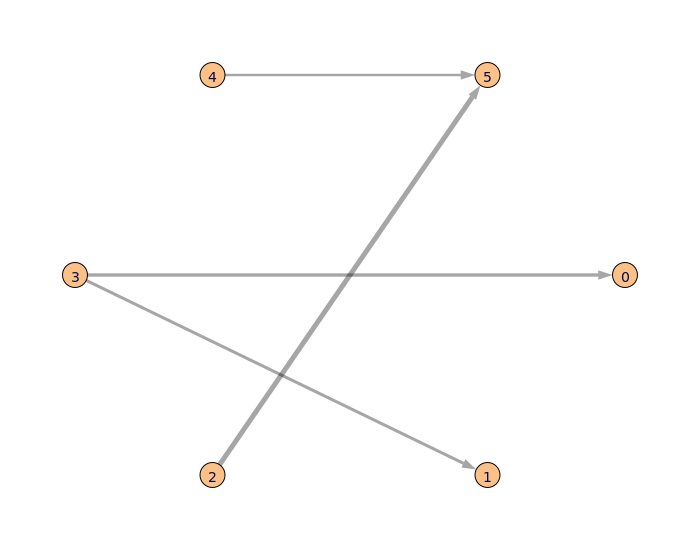

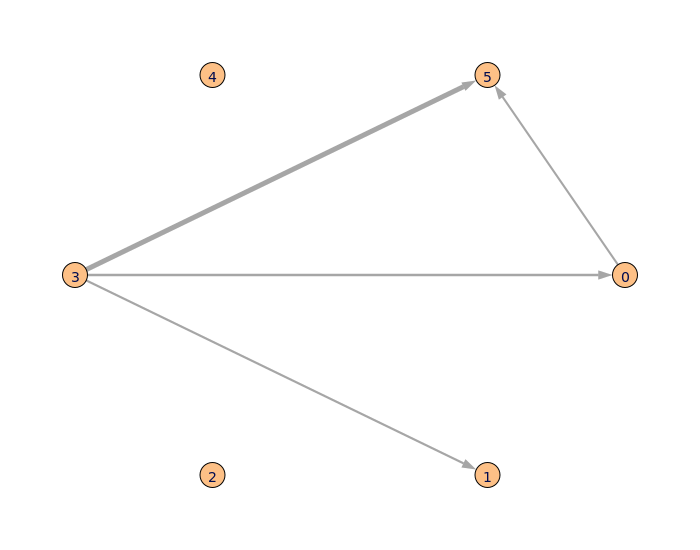

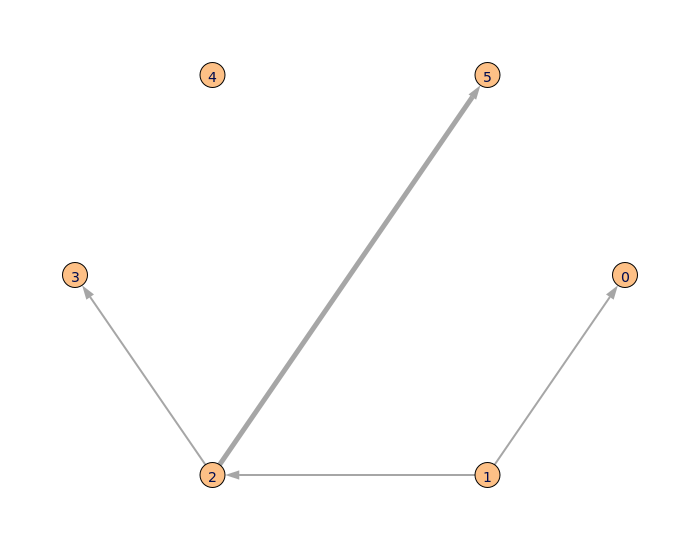

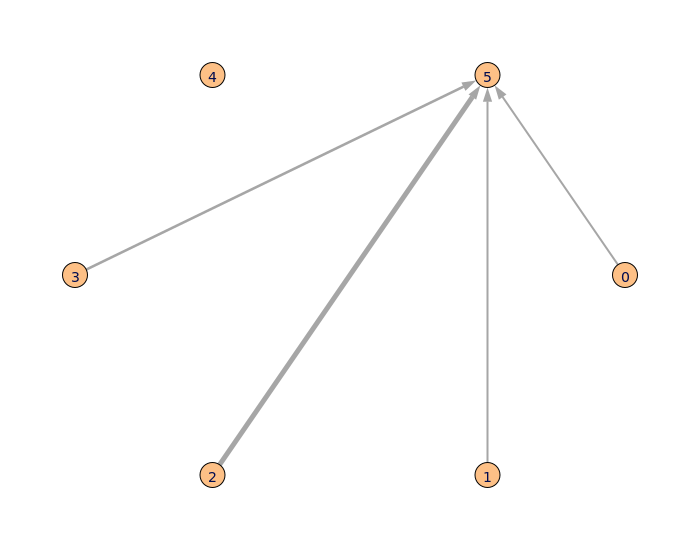

### i = 3

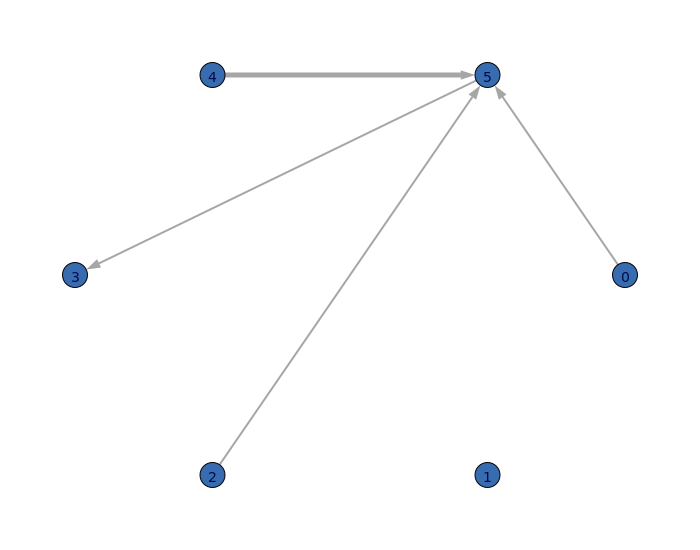

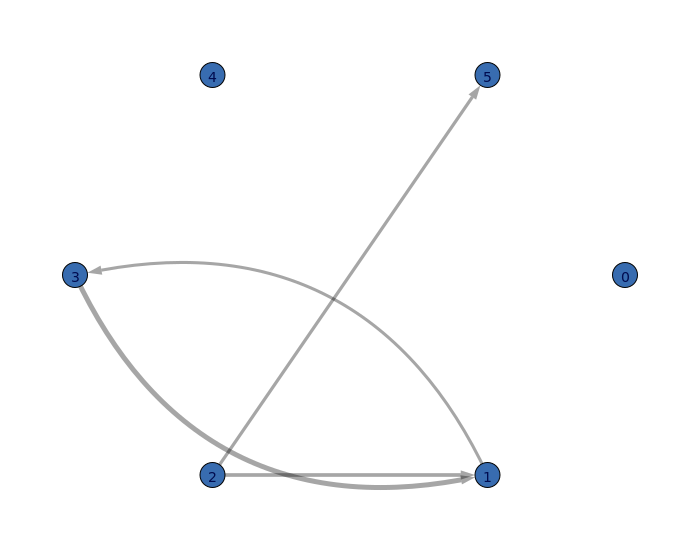

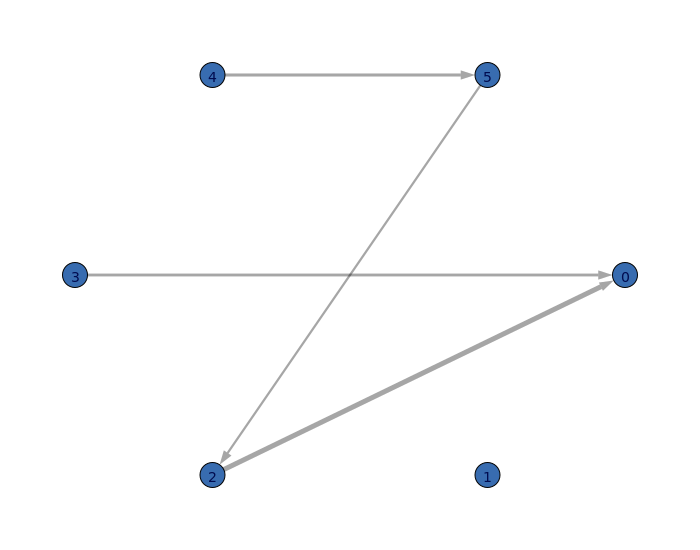

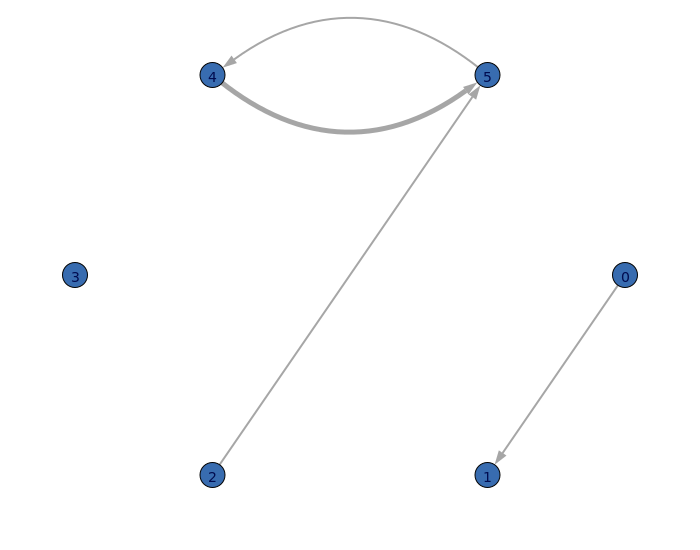

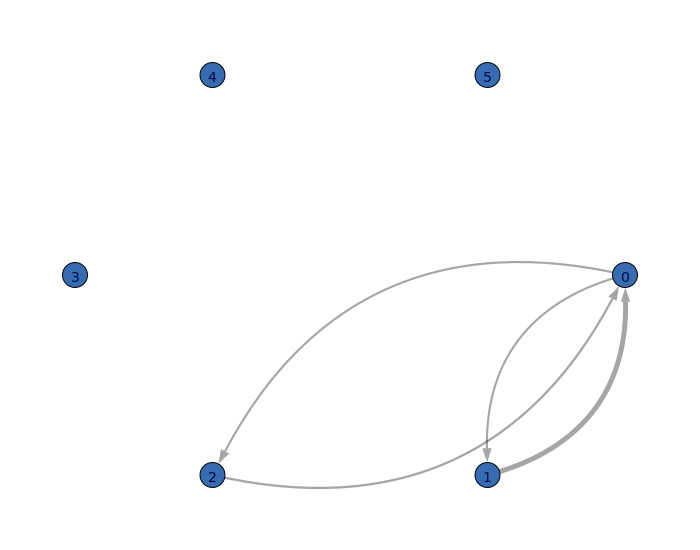

### i = 4

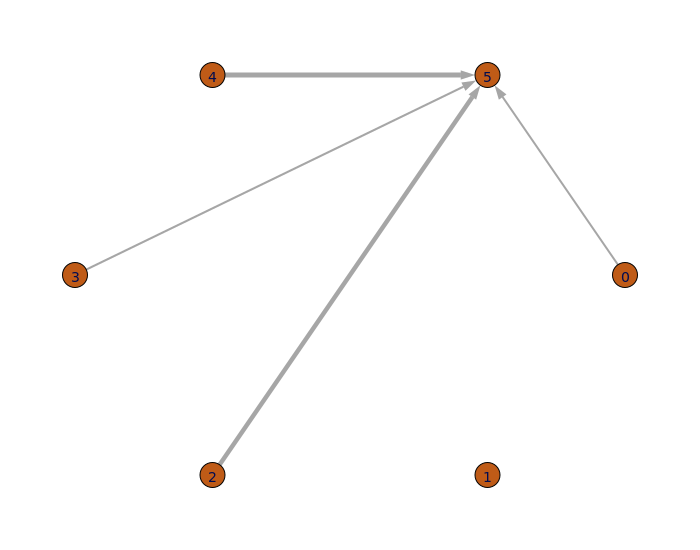

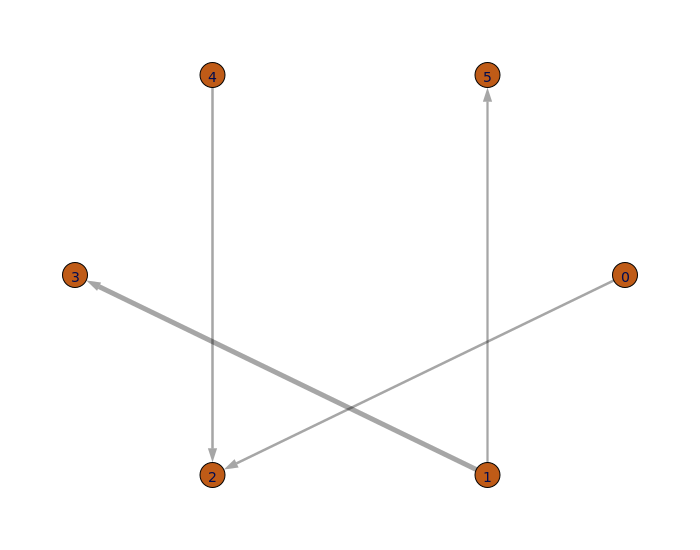

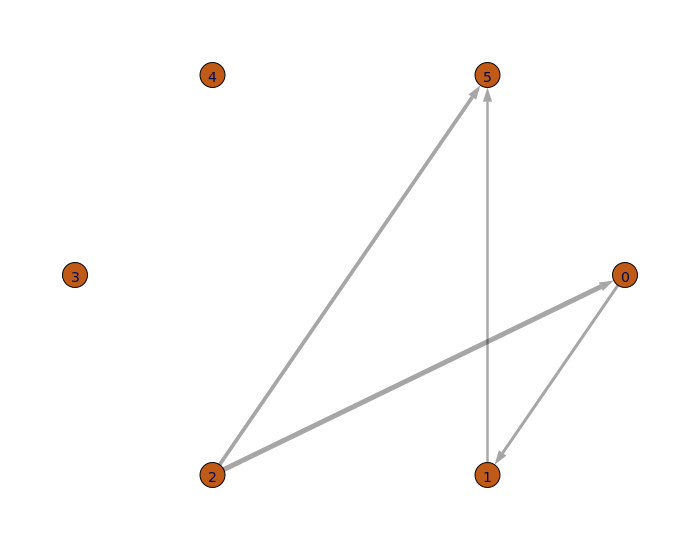

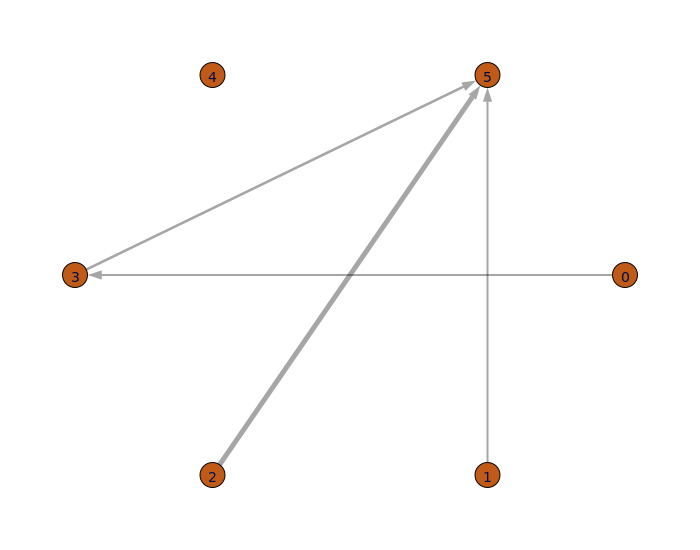

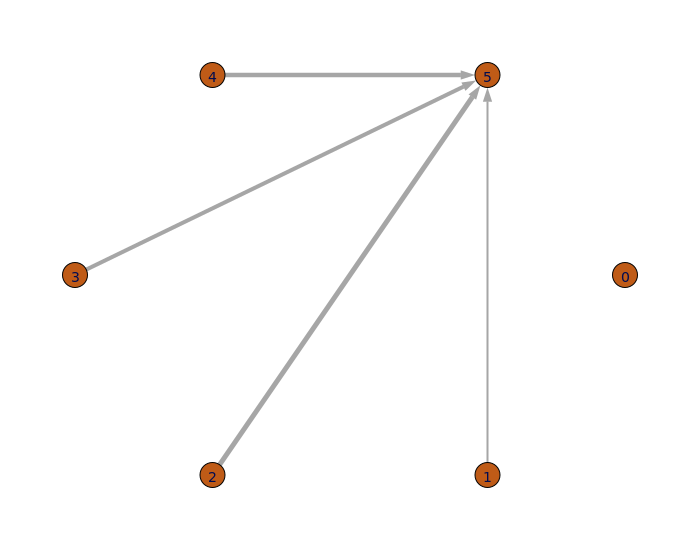

### i = 5

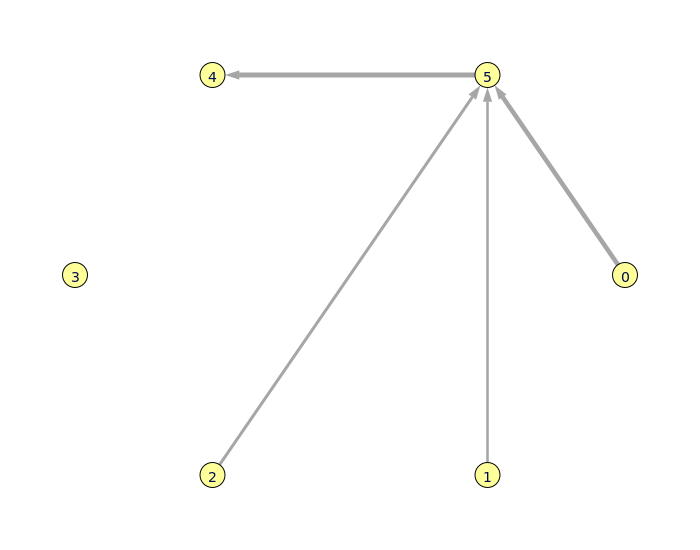

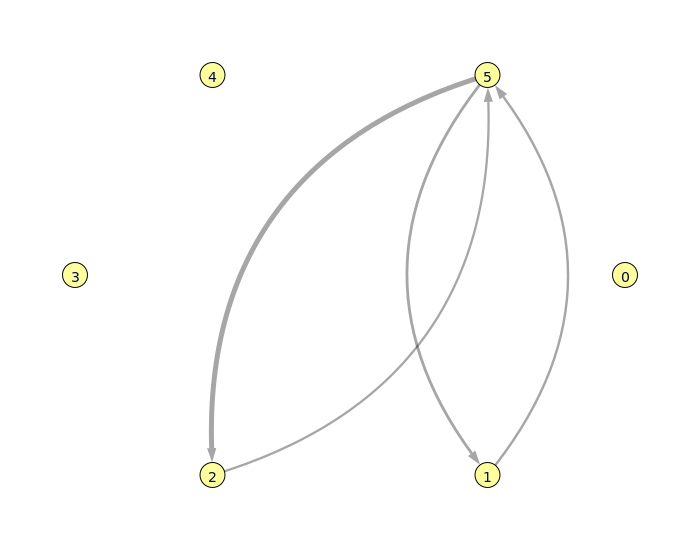

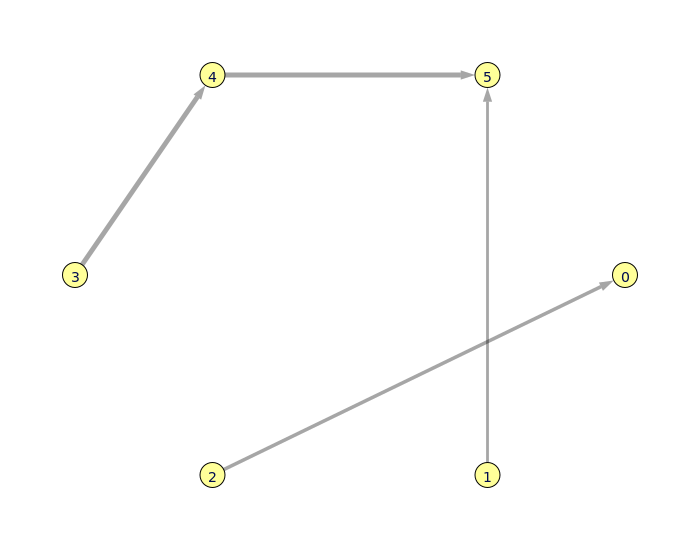

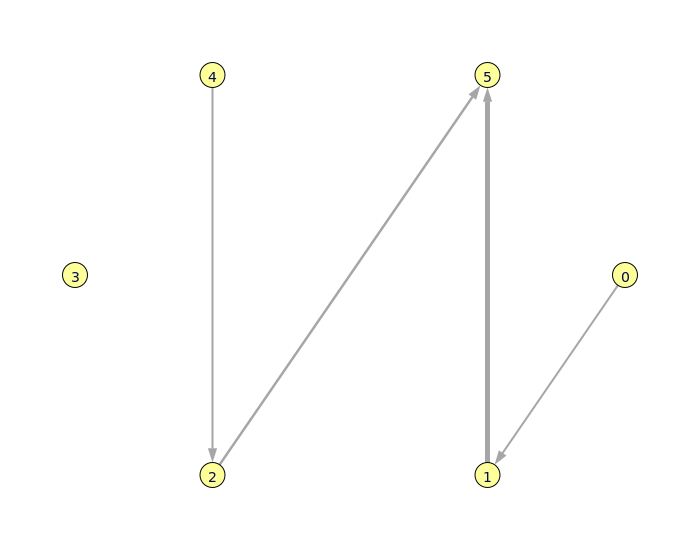

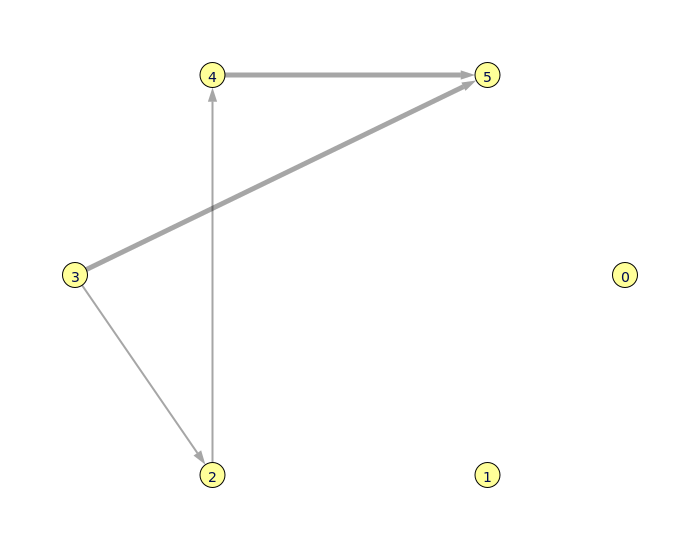

### i = 6

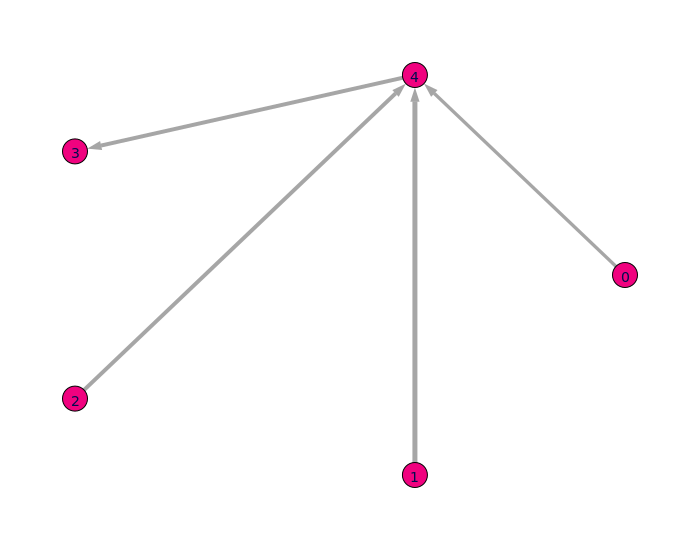

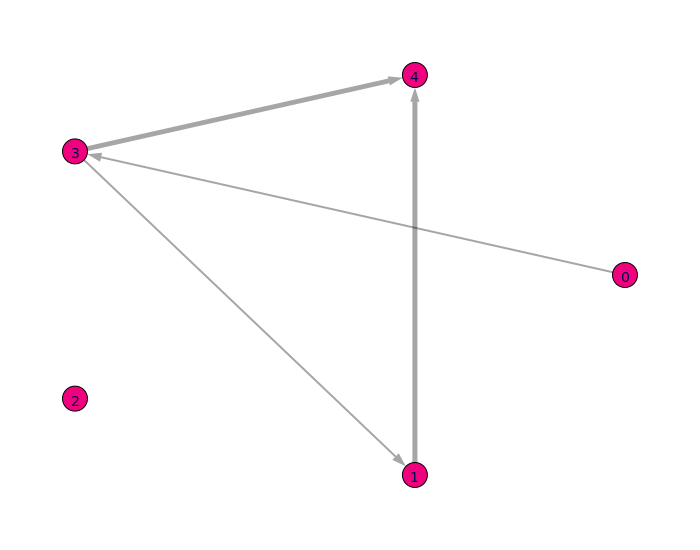

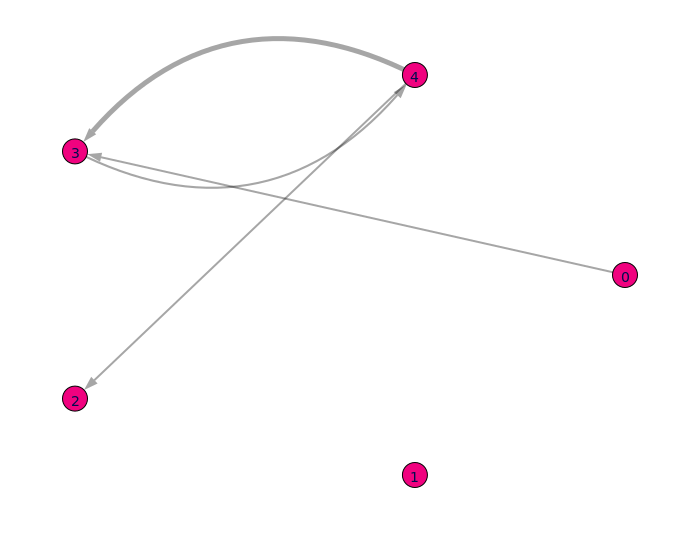

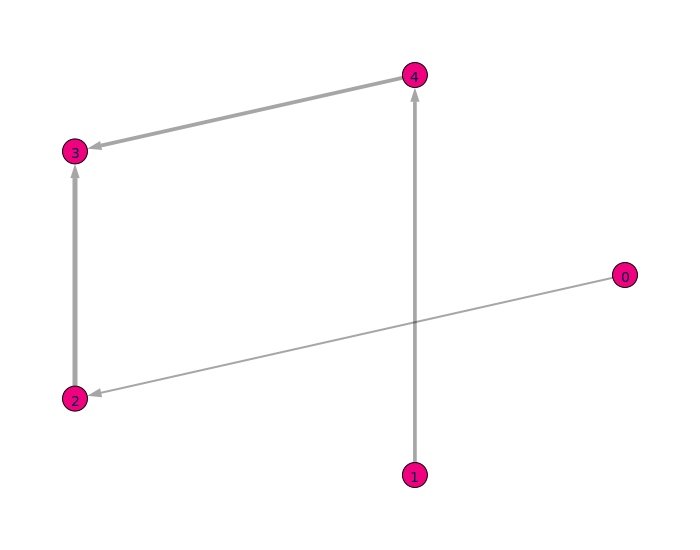

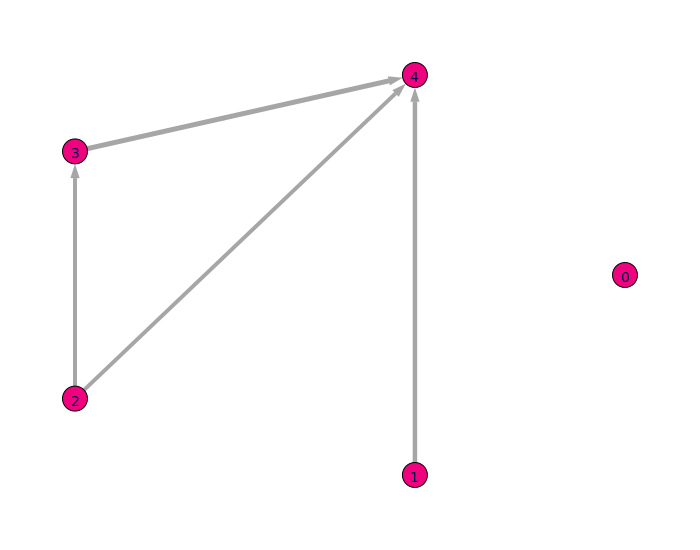

In [67]:
weightFunc = lambda g: [2 + 3*wt/max(g.es['weight']) for wt in g.es['weight']]

colorLst = ['rgb(127, 201, 127)',
            'rgb(190, 174, 212)',
            'rgb(253, 192, 134)',
            'rgb(56, 108, 176)',
            'rgb(191, 91, 23)',
            'rgb(255, 255, 153)',
            'rgb(240, 2, 127)',
            'rgb(102, 102, 102)']

for i in range(7):
    mdisp(f'### i = {i}')
    pp = df.iloc[i].pca
    vec = pp.components_[:, 0]
    vec[vec < sorted(vec, reverse=True)[3]] = 0  # NOTE: I'M CLIPPING THE VECTOR COMPONENTS!
    adjmat = graph.vec2squareMat(vec, addDiagonal=True)
    g = nx.from_numpy_matrix(adjmat, create_using=nx.DiGraph())
    gg = graph.networkx2igraph(g)
    layout = gg.layout_circle()
    disp(plotting.igdraw(gg, layout=layout, weightFunc=weightFunc, vertex_color=colorLst[i]))
    for j in range(2, 6):
        pp = df.iloc[i].pca
        vec = pp.components_[:, j]
        vec[vec < sorted(vec, reverse=True)[3]] = 0  # NOTE: I'M CLIPPING THE VECTOR COMPONENTS!
        adjmat = graph.vec2squareMat(vec, addDiagonal=True)
        g = nx.from_numpy_matrix(adjmat, create_using=nx.DiGraph()) 
        disp(plotting.igdraw(g, layout=layout, weightFunc=weightFunc, vertex_color=colorLst[i]))


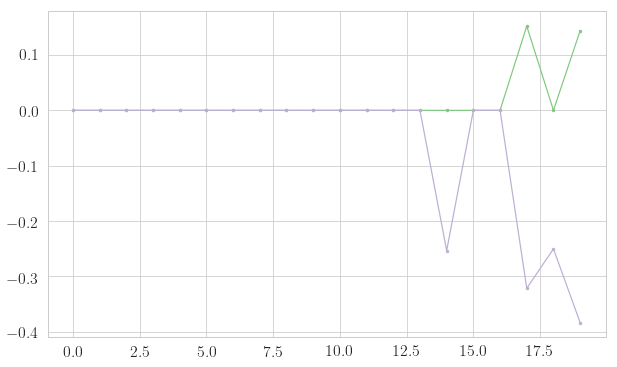

In [68]:
fig, ax = plt.subplots()
ax.plot(df.iloc[i].pca.components_[:, 2], '.-')
ax.plot(-1*df.iloc[i].pca.components_[:, 5], '.-') 